# Homework nr. 3 - features transformation & selection (deadline 22/11/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))
        
    # Print RMSLE
    print('Linear regression root mean squared validation error:',
          np.sqrt(metrics.mean_squared_log_error(clf.predict(Xv),yv)))
    if train_error:
        print('Linear regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_log_error(clf.predict(X), y)))
    
    

In [3]:
df = pd.read_csv('hw3_data.csv')
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = \
df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = \
df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

In [4]:
# Union all numbers datatype
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = \
df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

In [5]:
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print('Shape of the data:', df.shape)

Shape of the data: (1460, 320)


In [6]:
# Remove constant features
df = df[df.columns[df.min() != df.max()]]

In [7]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear regression root mean squared validation error: 0.16605330764268625
Linear regression root mean squared train error: 0.09812848302572498


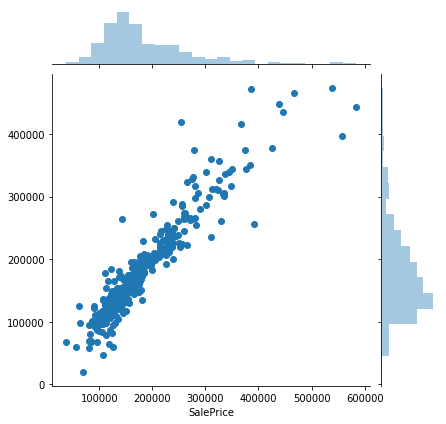

In [8]:
linreg(dt, dv, True)

In [9]:
columns_to_remove = ['Id']

# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
columns_to_remove = list(set(list(dt.columns[dt.var() < 0.00001]) + columns_to_remove)) # note that after the standardization all non-indicator variables have variance 1
# note that for an indicator with true prob p is the var given by p*(1-p) - for p = 0.01 we have 0.0099


In [10]:
dt = dt.drop(columns_to_remove, axis=1, errors = 'ignore')
dv = dv.drop(columns_to_remove, axis=1, errors = 'ignore')

In [11]:
linreg(dt, dv)

Linear regression root mean squared validation error: 0.16732343563409874
Linear regression root mean squared train error: 0.09823738837472144


In [12]:
# Correlation matrix Pearson & Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [13]:
# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# Spearman top 10 with target
corrS_cols = corrS.SalePrice.abs().nlargest(10).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice        1.000000
OverallQual      0.791963
SqrtGrLivArea    0.707052
GrLivArea        0.703866
GarageCars       0.645009
GarageArea       0.622276
Sqrt1stFlrSF     0.615341
1stFlrSF         0.615080
TotalBsmtSF      0.614957
ExterQual_TA    -0.574401
Name: SalePrice, dtype: float64

SalePrice         1.000000
OverallQual       0.810410
GrLivArea         0.735184
SqrtGrLivArea     0.735184
GarageCars        0.694128
GarageArea        0.648908
SqrtGarageArea    0.648908
YearBuilt         0.644751
FullBath          0.642719
GarageYrBlt       0.632785
Name: SalePrice, dtype: float64

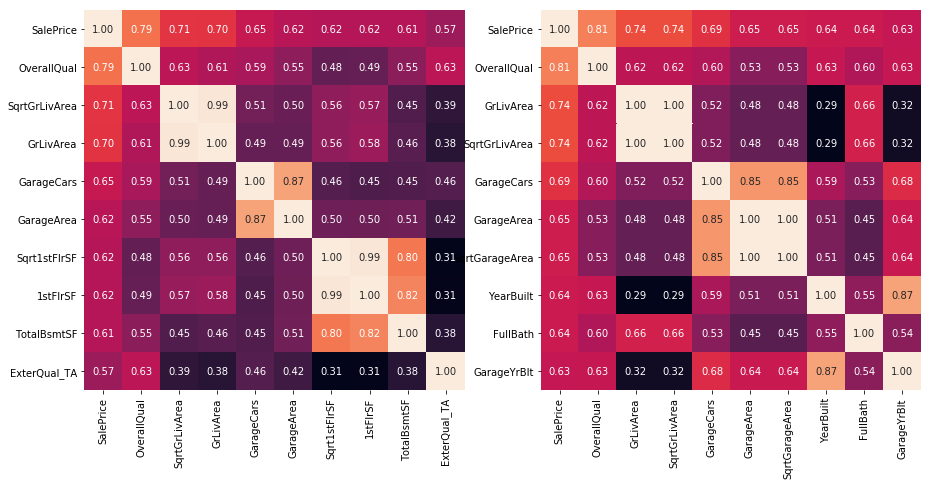

In [14]:
# Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

In [15]:
print(dt.shape)

(1095, 312)


In [16]:
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['BsmtFinSF2', 'BsmtHalfBath', 'Condition1_RRAn', 'Fence_GdPrv']


In [17]:
dt = dt.drop(columns_to_remove, axis=1, errors = 'ignore')
dv = dv.drop(columns_to_remove, axis=1, errors = 'ignore')

/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/03/__venv__/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear regression root mean squared validation error: 0.1684801411247792
Linear regression root mean squared train error: 0.09838924846067429


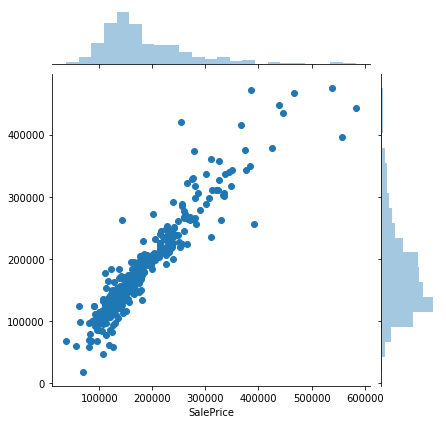

In [18]:
linreg(dt, dv, True)